In [1]:
import pickle
from pathlib import Path
import pandas as pd
import numpy as np
from smount_predictors import SeamountHelp
from smount_predictors.src.SeamountHelp import PipelinePredictor
import plotly.express as px
import plotly.graph_objects as go
import xarray as xr
import simplekml

model = pickle.load(open('out/script_accuracy_balenced_model.pkl', 'rb'))

In [25]:
def filter_seamounts(data: pd.DataFrame, seamounts: pd.DataFrame, height=800):
    """
    masks out seamounts which are larger than a threshold
    """
    to_remove = seamounts[seamounts['height'] >= height]
    to_remove['radius'] = to_remove['radius'] * 1.35  # artificially
    # inflate the radius to account for irrgeular shapes and low detail radius measurements
    masked = SeamountHelp.seamount_radial_match(data, to_remove)
    return masked[masked['Labels'] == 0]

In [37]:
points = (-19.2, -16.8, -112.9, -110.5)
data = SeamountHelp.readAndFilterGRD(Path('data/vgg_swot.grd'), points[:2], points[2:]).to_dataframe().reset_index()
seamounts = pd.read_csv('data/all.xyhrdnc', sep=' ', names=['lon', 'lat', 'height', 'radius', 'depth', 'name', 'class'])
masked_data = filter_seamounts(data, seamounts)
predictions = model.predict(masked_data[['lon', 'lat', 'z']]);

/var/folders/pv/8l65k1dd4wl0_vtr3mydz87w0160hr/T/ipykernel_3143/929657924.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/seamount_picking/code/smount_predictors/src/SeamountHelp.py:320: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = value

In [42]:
plot = px.scatter(predictions[predictions['cluster'] != -1], x='lon', y='lat', color='cluster').update_layout(
    width = 800,
    height=800).show()

871     -1
939     -1
957     -1
970     -1
971     -1
        ..
19849   -1
19850   -1
19851   -1
19992   -1
19994   -1
Name: cluster, Length: 16874, dtype: int64

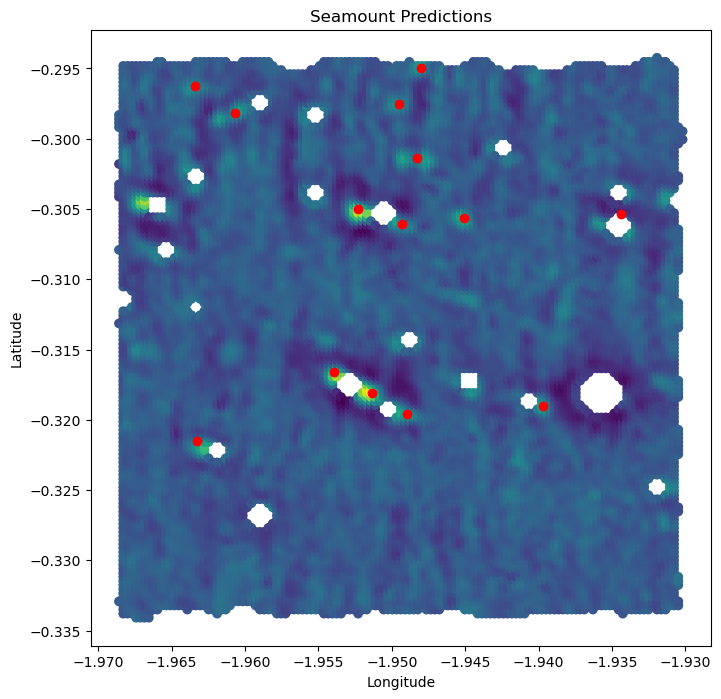

In [39]:
centers = predictions.groupby('cluster').mean()
centers['size'] = predictions.groupby('cluster').size()
centers = centers.drop([0, -1])
centers = centers[['lon', 'lat', 'size']]
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(predictions['lon'], predictions['lat'], c=predictions['z'], cmap='viridis')
ax.scatter(centers['lon'], centers['lat'], c='red')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Seamount Predictions')
plt.show()

In [40]:
predictions.to_csv('out/testing_zone_predictions.csv')

In [29]:
kml = simplekml.Kml()

for i, row in centers.iterrows():
    pnt = kml.newpoint(name=f'Cluster {i}', coords=[(np.degrees(row['lon']), np.degrees(row['lat']))])
    pnt.style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/paddle/red-circle.png'

# kml.save('out/predictions.kml')

In [7]:
!  open out/predictions.kml

In [3]:
predictions = pd.read_csv('out/predictions.csv')

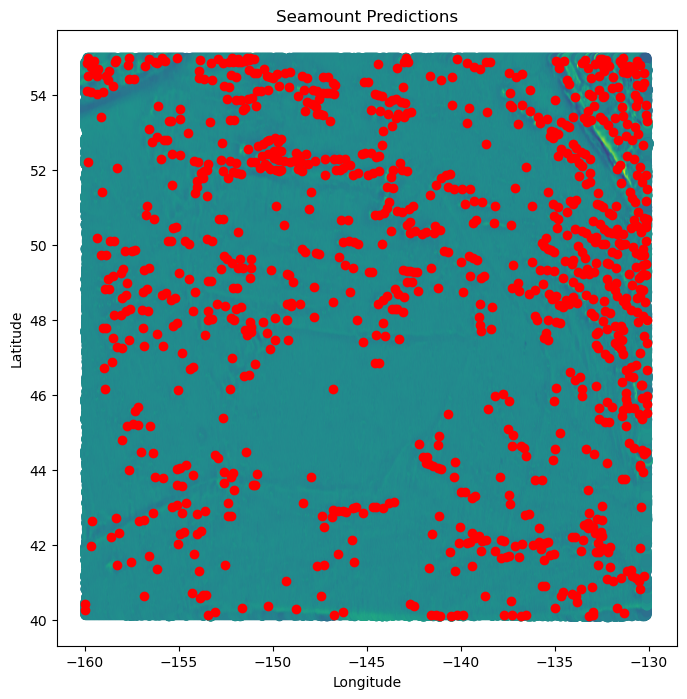

In [6]:
import matplotlib.pyplot as plt

centers = predictions.groupby('cluster').mean()
centers['size'] = predictions.groupby('cluster').size()
centers = centers.drop([0, -1])
centers = centers[['lon', 'lat', 'size']]

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(predictions['lon'], predictions['lat'], c=predictions['z'], cmap='viridis')
ax.scatter(centers['lon'], centers['lat'], c='red')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Seamount Predictions')
plt.show()